<a href="https://colab.research.google.com/github/sunfflur/frequency-learning-DHT/blob/main/frequency-learning-DHT/kylberg-texture-dataset/Exp_KTD_a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Experiment KTD

`Author:` [sunfflur](https://github.com/sunfflur)

> Experiment KTD uses the 28 classes from Kylberg Texture Dataset divided in 75% / 25% with 576x576 pixels of dimension each image and radius equal to 1, 2, 3 and 4. 1, 2, and 3 levels considered.



---

#### Setup

In [ ]:
s = 23
import os
os.environ['PYTHONHASHSEED']=str(s)
import random
random.seed(s)
from numpy.random import seed
seed(s)
from tensorflow.random import set_seed
set_seed(s)

import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.express as px
from tensorflow.keras.layers import Layer, Dense, Conv1D, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn

!pip install tensorflow-addons
!pip install tensorflow-recommenders

import tensorflow_addons as tfa
import tensorflow_recommenders as tfrs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 11 12:48:43 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#### Drive mount

In [ ]:
### TESSSSSST ###

!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
/usr/bin/xdg-open: 869: www-browser: not found
/usr/bin/xdg-open: 869: links2: not found
/usr/bin/xdg-open: 869: elinks: not found
/usr/bin/xdg-open: 869: links: not found
/usr/bin/xdg-open: 869: lynx: not found
/usr/bin/xdg-open: 869: w3m: not found
xdg-open: no method available for opening 'https://accounts.google.com/o/oauth2/auth?client_id=564921029129.apps.googleusercontent.com&redirect_uri=https%3A%2F%2Fgd-ocaml-auth.appspot.com%2Foauth2callback&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package w3m.
(Reading database ... 122523 files and directories currently installed.)
Preparing to unpack .../w3m_0.5.3-37ubuntu0.1_amd64.deb ...
Unpacking w3m (0.5.3-37ubuntu0.1) ...
Setting up w3m (0.5.3-37ubuntu0.1) ...
Processing triggers for man-db (2.9.1-1) ...
Processing triggers for mime-support (3.64ubuntu1) ...
/content
/content/drive
/content
/
Access token retrieved correctly.


#### Data preparation

In [ ]:
### data loading ###
path_train = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_train.npy'
path_ytrain = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_train.npy'
path_test = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_test.npy'
path_ytest = '/content/drive/MyDrive/Mestrado/Datasets/kylberg-dataset/kylberg_y_test.npy'

x_train, x_test = np.load(path_train), np.load(path_test)
y_train, y_test = np.load(path_ytrain), np.load(path_ytest)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# adjust dimension and change from array to tensor
new_shape = (576,576)
x_train, x_test = tf.image.resize(x_train, new_shape), tf.image.resize(x_test, new_shape)
y_train, y_test = tf.stack(to_categorical(y_train)), tf.stack(to_categorical(y_test))

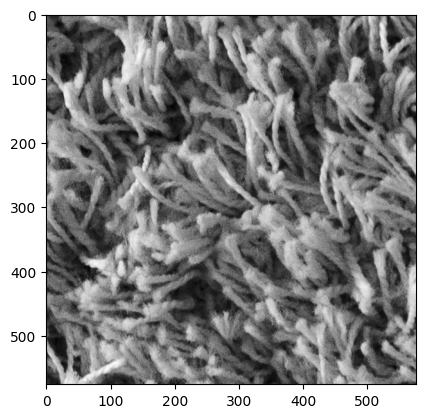

In [ ]:
plt.imshow(tf.squeeze(x_test[0]), cmap='gray') #0-rug1 (controle test)
plt.show()

#### Image Main Functions - Per Image

In [ ]:
### slicing PER IMAGE ###

''' here the images are splitted into blocks of same dimension, so we have an output that contains the number of images,
    the number of blocks the images were splitted, the 1st shape of the blocks, the second shape of the blocks and then the number of channels'''

def slice_data(images, levels):
  outputs = []
  if levels == 0:
    dim = int(tf.rank(images))
    if dim == 3:
      images = tf.expand_dims(images, -1)
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
    else:
      images = tf.transpose(images, [0, 3, 1, 2])
      return images
  for image in images:
    iM, iN = image.shape[0], image.shape[1] # shapes
    iMc, iNc = int(iM/2), int(iN/2) # image center
    output = tf.stack((image[:iMc, :iNc], image[:iMc,iNc:], image[iMc:,:iNc], image[iMc:, iNc:]),-1) # crop by index
    output = tf.reshape(output,[output.shape[0],output.shape[1], -1])
    outputs.append(output)
  outputs = tf.convert_to_tensor(outputs)
  return slice_data(outputs, levels-1) # output shape: (images, blocks, shape[0], shape[1], channels)

In [ ]:
### DFT PER IMAGE ###

''' here we calculate the Discrete Fourier Transform. The function is called for each block, so we move from the
    spatial to frequency domain keeping the same dimensions. '''

def m_spectrum(images):
  magnitudes = []
  for image in images:
    side = image.shape[1]
    inputx = tf.cast(image, tf.complex128) # change dtype to complex64
    fft = tf.signal.fft2d(inputx) # perform fast fourier transform
    fft_shift = tf.signal.fftshift(fft, axes=(1,2)) # shift the zero-frequency component to the center

    # calculate the magnitude and scale it
    magnitude = tf.math.abs(fft_shift)
    magnitude = tf.math.divide(magnitude, side**2)
    magnitude = tf.math.log(1+magnitude)
    magnitudes.append(magnitude)
  return tf.convert_to_tensor(magnitudes)

In [ ]:
''' after applying the magnitude sums we need to normalize the data to eb trained (now the coefficients)'''

def NormalizeData(X, max=1, min=0):
    ### data normalization between 0-1
    X_std = (X - tf.math.reduce_min(X)) / (tf.math.reduce_max(X) - tf.math.reduce_min(X))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [ ]:
### magnitude sums PER IMAGE ###

''' We can perform the magnitude sums considering euclidean or chebyshev distances. This function refers to the euclidean distance
    and was performed for testing, the chebyshev distance was calculated for the final experiments. both produce similar results.'''

def radial_grouping(images, r):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    A = tf.range(-iMc,iNc)**2
    dists = tf.math.sqrt(tf.cast(A[:,None] + A, dtype=tf.float64))
    dists = tf.reshape(dists, [1,image.shape[1],image.shape[2]]) #1,512,512
    n = int(iNc/r) #rings number
    magnitude_sums = []
    ring = 0
    for j in range(1, 2*n, 2):
      ring = tf.cast((tf.abs(dists-(r/2)*j)<(r/2)), dtype=tf.float64)
      if j == 1:
        ring = tf.cast((tf.abs(dists-(r/2)*j)<=(r/2)), dtype=tf.float64)
      mult = tf.multiply(ring,image)
      sum = tf.reduce_sum(mult,axis=(1,2))
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

In [ ]:
### magnitude sums PER IMAGE ###

''' Here we create the functions to calculate the chebyshev distance when creating each ring. This option is faster than the previous one but produces
    similar results after training. '''

def create_square(size=None, radius=None, width=None):
  image = np.zeros((size, size))
  center = (size-1) / 2
  linhas=np.arange(0,size,1).reshape(size,1) #u
  colunas=np.arange(0,size,1).reshape(1,size) #v
  condition_1=np.abs(linhas-center) # |x1-x2|
  condition_2=np.abs(colunas-center) # |y1-y2|
  maximo=np.maximum(condition_1,condition_2) # max(|x1-x2|,|y1-y2|) # chebyshev
  desigualdade=np.less_equal(maximo,radius)
  desigualdade_2=np.greater(maximo,radius-width) # max <= r
  return np.logical_and(desigualdade,desigualdade_2).astype(np.float64)

def square_grouping(images, w):
  grouping = []
  for image in images:
    iM, iN = image.shape[1], image.shape[2] #image dimension
    iMc, iNc = int(iM/2), int(iN/2) #image center
    magnitude_sums = []
    for r in range(w, (iM//2)+1, w):
      ring = create_square(iM, r, w)
      ring = tf.convert_to_tensor(ring, dtype=tf.float64)
      mult = tf.multiply(ring, image) # performs the product between the block and the ring
      sum = tf.reduce_sum(mult,axis=(1,2)) # sums the output
      magnitude_sums.append(sum.numpy())
    magnitude_sums = tf.convert_to_tensor(magnitude_sums)
    grouping.append(magnitude_sums)
  grouping = tf.convert_to_tensor(grouping)
  grouping = tf.reshape(grouping, [grouping.shape[0], -1])
  return grouping

#### Data Pre-Process - 3 levels

In [ ]:
''' Here we create a class to preprocess the data, which means we have as input the 'x_train/test/valid' and produces as output
    the coefficients that are going to be used as input on the frequency layer. On this function the images follows through the stages
    defined: slicing, DFT and magnitude sums (grouping). At the end, the data is normalized between 0-1.

    To call this class, we need to defined which are the data (images of shape (N, shape[0], shape[1], channels), the number of slicing levels
    and the width (w) of the rings)'''

class PreProcess():
  def __init__(self, data, level, w): #level = levels number; r = radius (ring width);
    self.data = data #x_train/test
    self.level = level
    self.w = w
  def processing(self):
    conc_channels = []
    for i in range(0, self.level+1):
      print('level:', i)
      for j in range(0, self.data.shape[3]):
        print('channel:', j)
        sliced_data = slice_data(self.data[:,:,:,j], levels=i)
        #print('sliced:', sliced_data.shape)
        dft_data = m_spectrum(sliced_data)
        #grouping_data = radial_grouping(dft_data, r=self.r) # r = radius (ring width)
        grouping_data = square_grouping(dft_data, w=self.w) # r = radius (ring width)
        conc_channels.append(grouping_data)
        del sliced_data
        del dft_data
        del grouping_data
      conc = tf.concat((conc_channels), axis=1)
    input_train = tf.concat((conc), axis=1)
    inp = NormalizeData(input_train)
    input_train = tf.convert_to_tensor(inp)
    return input_train#, sliced_data, dft_data

##### Width==1

In [ ]:
with tf.device('/CPU:0'):
  input, sliced_data, dft_data = PreProcess(x_train, level=2, w=1).processing() #2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

In [ ]:
np.save('input_train_exp2_w1_l2_radial.npy', input)

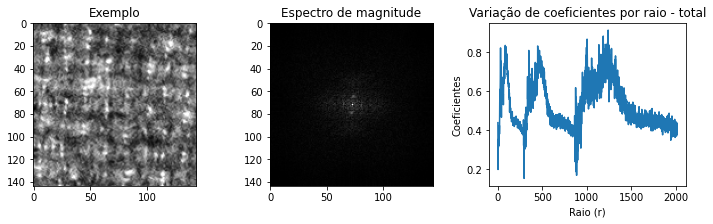

In [ ]:
example = 3
block = 0
x = input[example]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(sliced_data[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio - total'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

In [ ]:
with tf.device('/CPU:0'):
  input_test, sliced_data_test, dft_data_test = PreProcess(x_test, level=2, r=1).processing()

In [ ]:
input_test.shape ### test set shape

TensorShape([1120, 2016])

In [ ]:
sliced_data_test.shape #ultima parte do pre-processamento: 16 blocos 144x144

TensorShape([1120, 16, 144, 144])

In [ ]:
np.save('input_test_exp2_w1_l2_radial.npy', input_test)

In [ ]:
!nvidia-smi

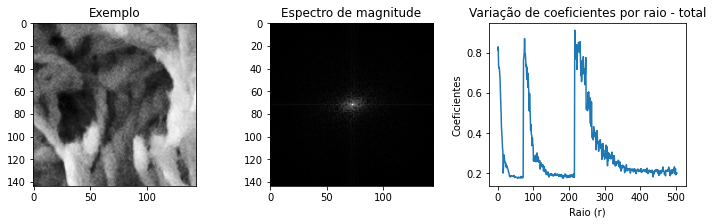

In [ ]:
example = 0
block = 0
x = input_test[example]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(sliced_data_test[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data_test[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio - total'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

##### Width==2



In [ ]:
with tf.device('/CPU:0'):
  input_train = PreProcess(x_train, level=2, w=2).processing() #, sliced_data, dft_data  #2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save(folder + 'input_train_exp2_w2_l2_square_dft.npy', input_train)

In [ ]:
example = 3
block = 0
x = input_train[example]

plt.figure(figsize=(12,3))
plt.subplot(131), plt.imshow(sliced_data[example, block,:,:], cmap='gray')
plt.title('Exemplo')
plt.subplot(132), plt.imshow(dft_data[example, block,:,:], cmap='gray')
plt.title('Espectro de magnitude')
plt.subplot(133), plt.plot(x)
plt.title('Variação de coeficientes por raio - total'), plt.xlabel('Raio (r)'), plt.ylabel('Coeficientes')
plt.show()

In [ ]:
with tf.device('/CPU:0'):
  input_test = PreProcess(x_test, level=2, w=2).processing() #, sliced_data_test, dft_data_test

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save('input_test_exp2_w2_l2_square_dft.npy', input_test)

##### Width==3



In [ ]:
with tf.device('/CPU:0'):
  input_train = PreProcess(x_train, level=2, w=3).processing() #, sliced_data, dft_data, 2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save(folder + 'input_train_exp2_w3_l2_square_dft.npy', input_train)

In [ ]:
with tf.device('/CPU:0'):
  input_test = PreProcess(x_test, level=2, w=3).processing() #, sliced_data_test, dft_data_test

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save(folder + 'input_test_exp2_w3_l2_square_dft.npy', input_test)

##### Width==4



In [ ]:
with tf.device('/CPU:0'):
  input_train = PreProcess(x_train, level=2, w=4).processing() #, sliced_data, dft_data, 2 levels means original image + division in 4 blocks + division in 16 blocks (4 blocks again)

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save(folder+'input_train_exp2_w4_l2_square_dft.npy', input_train)

In [ ]:
with tf.device('/CPU:0'):
  input_test = PreProcess(x_test, level=2, w=4).processing() #, sliced_data_test, dft_data_test

level: 0
channel: 0
level: 1
channel: 0
level: 2
channel: 0


In [ ]:
folder = '/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/'
np.save(folder + 'input_test_exp2_w4_l2_square_dft.npy', input_test)

#### Data Load

In [ ]:
### Saved Pre-Processed data LOAD ###
input_train = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_train_exp2_w1_l2_square.npy')) ### train 96+192+384=672 / 72+144+288=504
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_test_exp2_w1_l2_square.npy')) ### test

In [ ]:
input_1 =  input_train[:,:288]
input_test_1 = input_test[:,:288]

In [ ]:
input_1.shape

TensorShape([3360, 288])

In [ ]:
input_2 =  input_train[:, :288*3]
input_test_2 = input_test[:,:288*3]

In [ ]:
input_2.shape

TensorShape([3360, 864])

In [ ]:
input_test.shape

TensorShape([1120, 2016])

In [ ]:
input_3 =  input_train[:,:]
input_test_3 = input_test[:,:]

In [ ]:
input_3.shape

TensorShape([3360, 2016])

#### Custom Layer

In [ ]:
''' Here we create the Frequency Layer that are going to perform the convolution operation in the frequency
    domain. In this scenario, the convolution is a product between the coefficients and the filter.'''

class FreqLayer(Layer):
  def __init__(self, units, kernel_initializer='RandomNormal', extra_layers='Dense', output_type='Dense', **kwargs):
    super().__init__(**kwargs)
    self.units = units
    self.kernel_initializer = kernel_initializer
    self.extra_layers = extra_layers
    self.output_type = output_type
  def get_config(self):
    config = super(FreqLayer, self).get_config()
    config.update({
      "units": self.units,
      "kernel_initializer": self.kernel_initializer,
      "extra_layers": self.extra_layers,
      "output_type": self.output_type
      })
    return config
  def build(self, batch_input_shape):
    if self.extra_layers == 'Dense':
      shape = [batch_input_shape[-1],self.units] #(weights,) - shape for dense training
    else:
      shape = [batch_input_shape[-2],1] #(weights, 1) - shape for convolutional training
    self.kernel = self.add_weight(
        name='kernel',
        shape = shape,
        initializer=self.kernel_initializer,
        trainable=True)
    super().build(batch_input_shape) # must be at the end
  def call(self, X):
    #### fourier and hartley convolution can be the same due to the filter even symmetry ####
    f = tf.expand_dims(X, -1)*self.kernel
    return f
  def compute_output_shape(self, batch_input_shape):
    if self.output_type == 'Dense':
      return tf.TensorShape(batch_input_shape.as_list()[:-1] + [self.units]) #[examples,1] - dense
    else:
      return tf.TensorShape(batch_input_shape.as_list()[:-2] + [self.units]) #[examples,1] - conv1d

### Experiments performed can be accessed below. 3, 2 and 1 levels were considered.

#### Model_3levels

##### Width==1

In [ ]:
tf.random.set_seed(25)
init = 'glorot_normal'
function = 'ReLU'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_train.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_train, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True) #validation_split=0.1

Epoch 1/500
336/336 [==============================] - 6s 3ms/step - loss: 1.7067 - accuracy: 0.4506
Epoch 2/500
336/336 [==============================] - 1s 2ms/step - loss: 0.6851 - accuracy: 0.7604
Epoch 3/500
336/336 [==============================] - 1s 2ms/step - loss: 0.4620 - accuracy: 0.8399
Epoch 4/500
336/336 [==============================] - 1s 2ms/step - loss: 0.3973 - accuracy: 0.8643
Epoch 5/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2551 - accuracy: 0.9125
Epoch 6/500
336/336 [==============================] - 1s 3ms/step - loss: 0.3422 - accuracy: 0.8875
Epoch 7/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2258 - accuracy: 0.9193
Epoch 8/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2366 - accuracy: 0.9247
Epoch 9/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1928 - accuracy: 0.9298
Epoch 10/500
336/336 [==============================] - 1s 2ms/step - loss: 0.2453 - accura

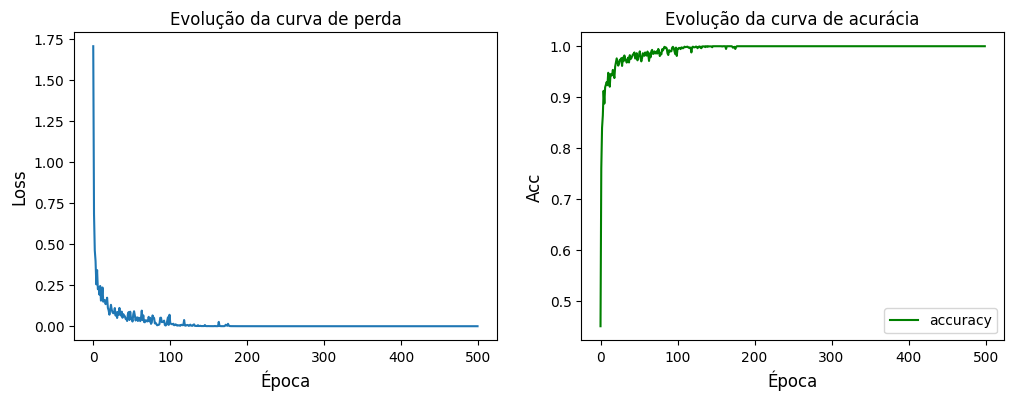

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ### training: 7min14s
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0077 - accuracy: 0.9973

accuracy : 99.73%


35/35 [==============================] - 0s 2ms/step


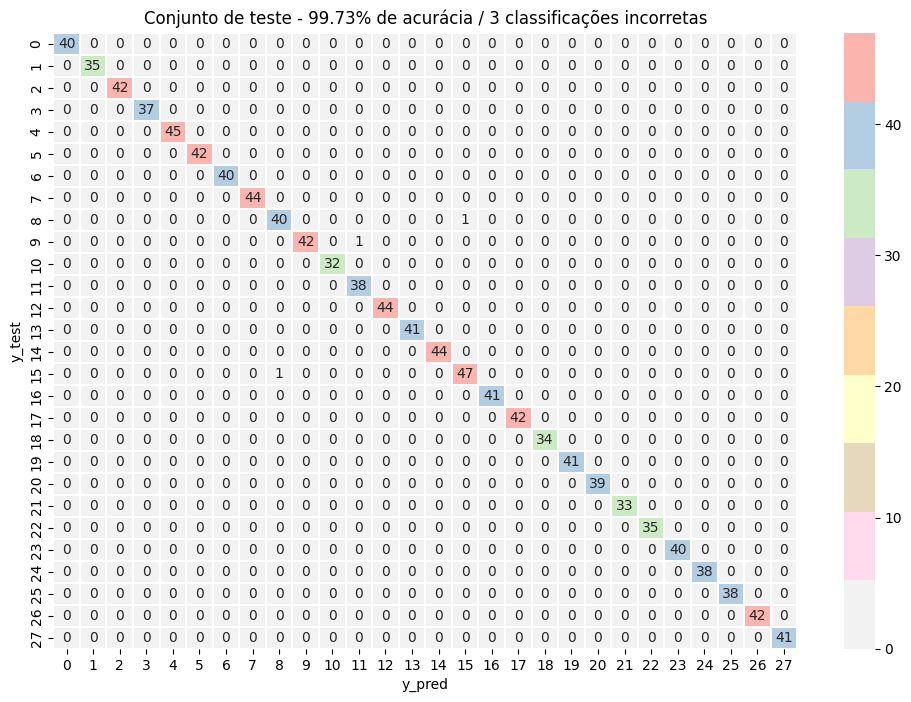

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
np.savetxt('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-pynb/cm_exp2a_dft.txt',cm)

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

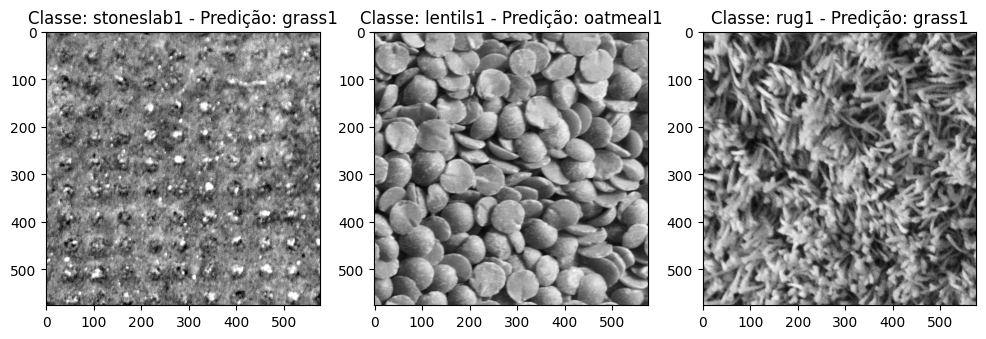

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_17 (FreqLayer)   (None, 2016, 1)           2016      
                                                                 
 flatten_15 (Flatten)        (None, 2016)              0         
                                                                 
 dense_49 (Dense)            (None, 128)               258176    
                                                                 
 dense_50 (Dense)            (None, 128)               16512     
                                                                 
 dense_51 (Dense)            (None, 28)                3612      
                                                                 
Total params: 280,316
Trainable params: 280,316
Non-trainable params: 0
_________________________________________________________________


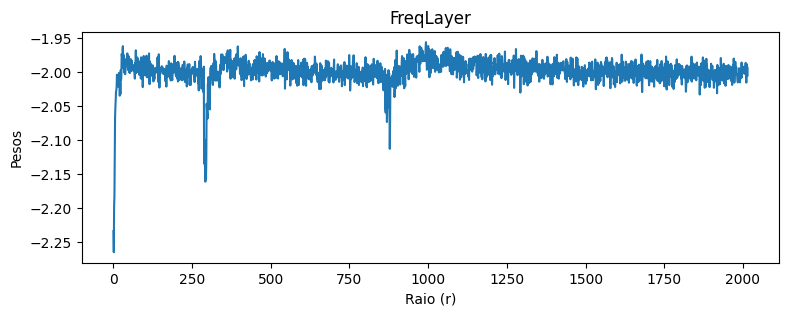

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

##### Width==2

In [ ]:
### Saved Pre-Processed data LOAD ###
input_train = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_train_exp2_w2_l2_square_dft.npy')) ### train 96+192+384=672 / 72+144+288=504
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_test_exp2_w2_l2_square_dft.npy')) ### test

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=2, stddev=0.001)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_train.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_train, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True, validation_split=0.1)

Epoch 1/500
303/303 [==============================] - 6s 4ms/step - loss: 2.3604 - accuracy: 0.2483 - val_loss: 1.6613 - val_accuracy: 0.4554
Epoch 2/500
303/303 [==============================] - 1s 3ms/step - loss: 1.2930 - accuracy: 0.5797 - val_loss: 0.8405 - val_accuracy: 0.7173
Epoch 3/500
303/303 [==============================] - 1s 3ms/step - loss: 0.7428 - accuracy: 0.7467 - val_loss: 0.6221 - val_accuracy: 0.7768
Epoch 4/500
303/303 [==============================] - 1s 4ms/step - loss: 0.5656 - accuracy: 0.8006 - val_loss: 0.5969 - val_accuracy: 0.7500
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 0.5025 - accuracy: 0.8234 - val_loss: 0.5273 - val_accuracy: 0.7708
Epoch 6/500
303/303 [==============================] - 1s 3ms/step - loss: 0.4479 - accuracy: 0.8485 - val_loss: 0.2680 - val_accuracy: 0.9107
Epoch 7/500
303/303 [==============================] - 1s 3ms/step - loss: 0.4016 - accuracy: 0.8502 - val_loss: 0.2667 - val_accuracy: 0.8929

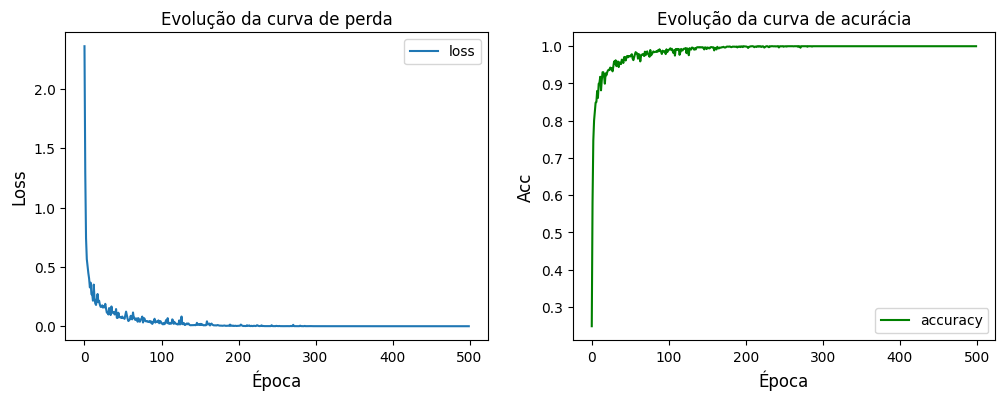

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0130 - accuracy: 0.9937

accuracy : 99.37%


In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

35/35 [==============================] - 0s 1ms/step


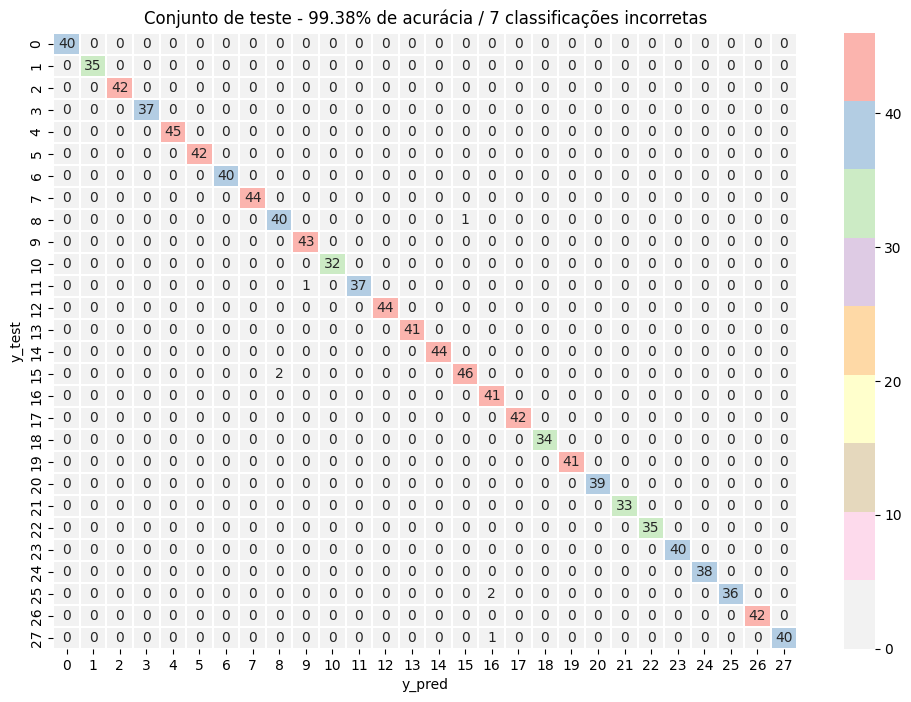

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')

plt.show()

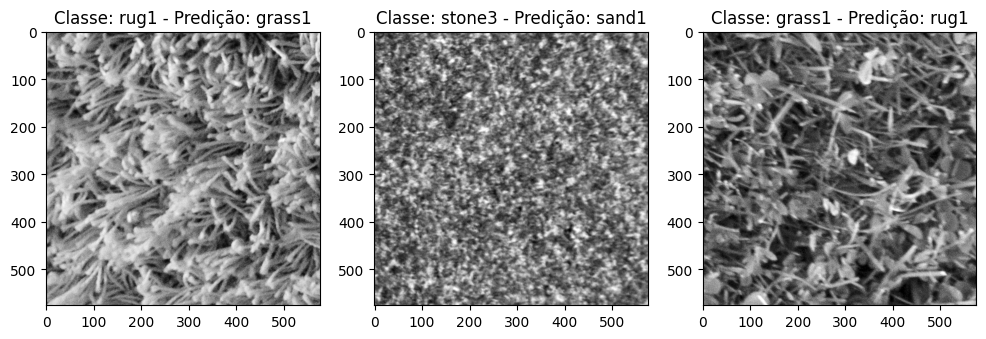

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer (FreqLayer)      (None, 1008, 1)           1008      
                                                                 
 flatten (Flatten)           (None, 1008)              0         
                                                                 
 dense (Dense)               (None, 128)               129152    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 28)                3612      
                                                                 
Total params: 150,284
Trainable params: 150,284
Non-trainable params: 0
_________________________________________________________________


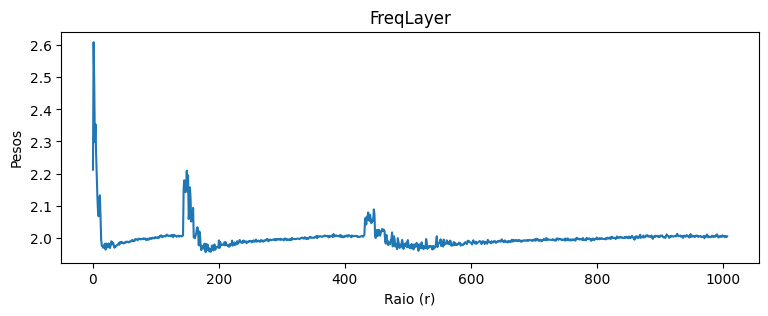

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

##### Width==3

In [ ]:
### Saved Pre-Processed data LOAD ###
input_train = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_train_exp2_w3_l2_square_dft.npy')) ### train 96+192+384=672 / 72+144+288=504
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_test_exp2_w3_l2_square_dft.npy')) ### test

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=2, stddev=0.001)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_train.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_train, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True, validation_split=0.1)

Epoch 1/500
303/303 [==============================] - 3s 4ms/step - loss: 2.3017 - accuracy: 0.2675 - val_loss: 1.4786 - val_accuracy: 0.5476
Epoch 2/500
303/303 [==============================] - 1s 4ms/step - loss: 1.1686 - accuracy: 0.6187 - val_loss: 0.8434 - val_accuracy: 0.7262
Epoch 3/500
303/303 [==============================] - 1s 4ms/step - loss: 0.7101 - accuracy: 0.7579 - val_loss: 0.6190 - val_accuracy: 0.7589
Epoch 4/500
303/303 [==============================] - 1s 4ms/step - loss: 0.5592 - accuracy: 0.7993 - val_loss: 0.6561 - val_accuracy: 0.7679
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 0.4544 - accuracy: 0.8360 - val_loss: 0.5413 - val_accuracy: 0.7768
Epoch 6/500
303/303 [==============================] - 1s 4ms/step - loss: 0.3894 - accuracy: 0.8638 - val_loss: 0.2626 - val_accuracy: 0.9137
Epoch 7/500
303/303 [==============================] - 1s 4ms/step - loss: 0.3650 - accuracy: 0.8628 - val_loss: 0.2976 - val_accuracy: 0.8720

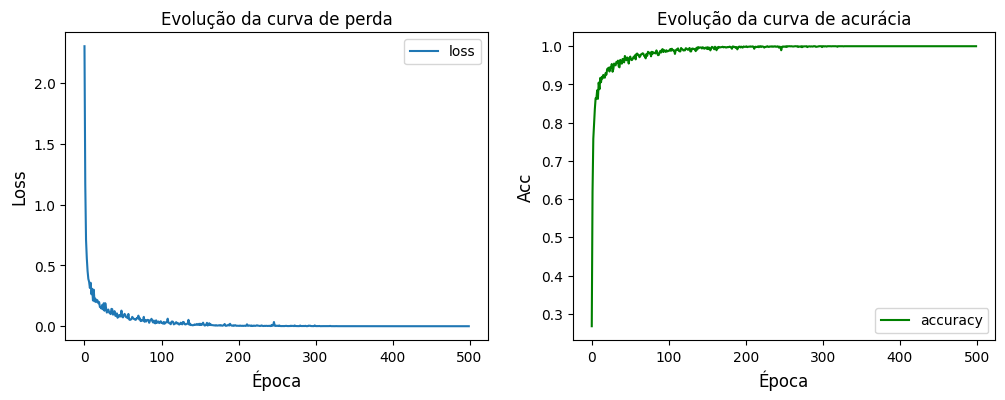

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 3ms/step - loss: 0.0199 - accuracy: 0.9911

accuracy : 99.11%


In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

35/35 [==============================] - 0s 1ms/step


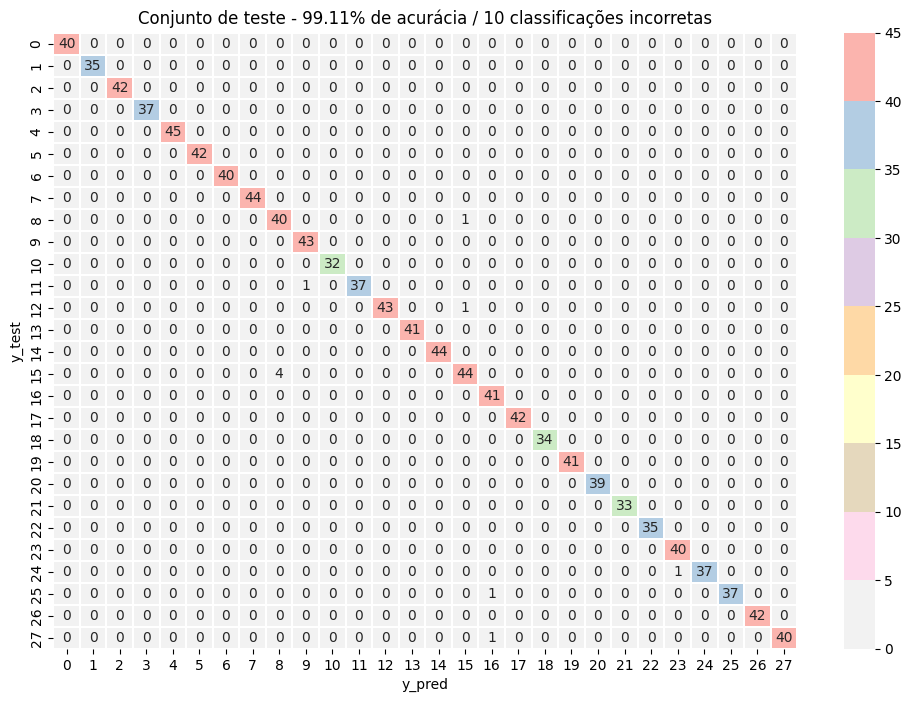

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')

plt.show()

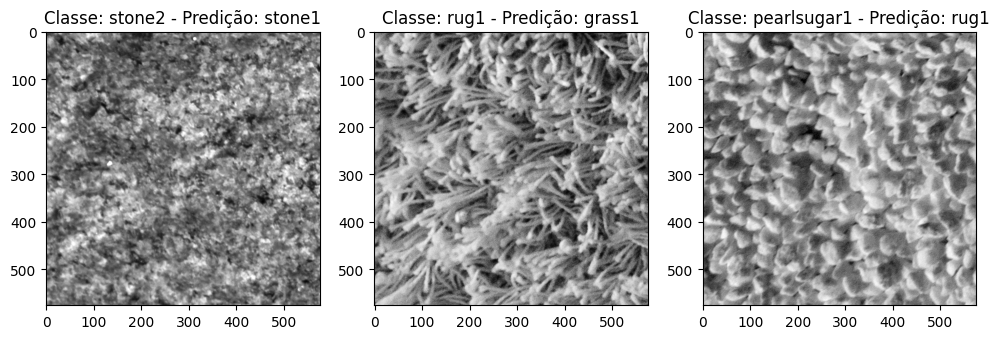

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_8 (FreqLayer)    (None, 672, 1)            672       
                                                                 
 flatten_8 (Flatten)         (None, 672)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               86144     
                                                                 
 dense_23 (Dense)            (None, 128)               16512     
                                                                 
 dense_24 (Dense)            (None, 28)                3612      
                                                                 
Total params: 106,940
Trainable params: 106,940
Non-trainable params: 0
_________________________________________________________________


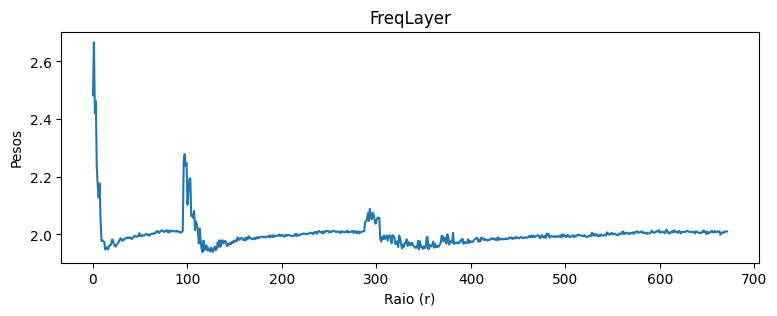

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

##### Width==4

In [ ]:
### Saved Pre-Processed data LOAD ###
input_train = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_train_exp2_w4_l2_square_dft.npy')) ### train 96+192+384=672 / 72+144+288=504
input_test = tf.convert_to_tensor(np.load('/content/drive/MyDrive/Mestrado/Experimentos/exp2-KTD/exp2-data/square-grouping/3-levels/input_test_exp2_w4_l2_square_dft.npy')) ### test

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=2, stddev=0.001)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_train.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_train, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True, validation_split=0.1) #9min20s

Epoch 1/500
303/303 [==============================] - 2s 4ms/step - loss: 2.3146 - accuracy: 0.2639 - val_loss: 1.6534 - val_accuracy: 0.4702
Epoch 2/500
303/303 [==============================] - 1s 4ms/step - loss: 1.3336 - accuracy: 0.5638 - val_loss: 1.0775 - val_accuracy: 0.6429
Epoch 3/500
303/303 [==============================] - 1s 4ms/step - loss: 0.8126 - accuracy: 0.7278 - val_loss: 0.7110 - val_accuracy: 0.7173
Epoch 4/500
303/303 [==============================] - 1s 3ms/step - loss: 0.6035 - accuracy: 0.7894 - val_loss: 0.6772 - val_accuracy: 0.7738
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 0.5021 - accuracy: 0.8228 - val_loss: 0.5085 - val_accuracy: 0.8065
Epoch 6/500
303/303 [==============================] - 1s 3ms/step - loss: 0.4219 - accuracy: 0.8542 - val_loss: 0.3197 - val_accuracy: 0.8988
Epoch 7/500
303/303 [==============================] - 1s 3ms/step - loss: 0.4216 - accuracy: 0.8383 - val_loss: 0.3254 - val_accuracy: 0.8988

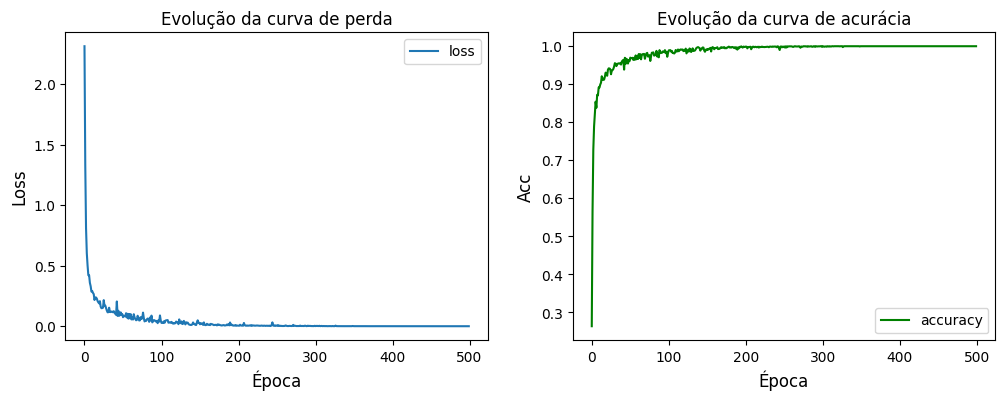

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0246 - accuracy: 0.9902

accuracy : 99.02%


In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

35/35 [==============================] - 0s 1ms/step


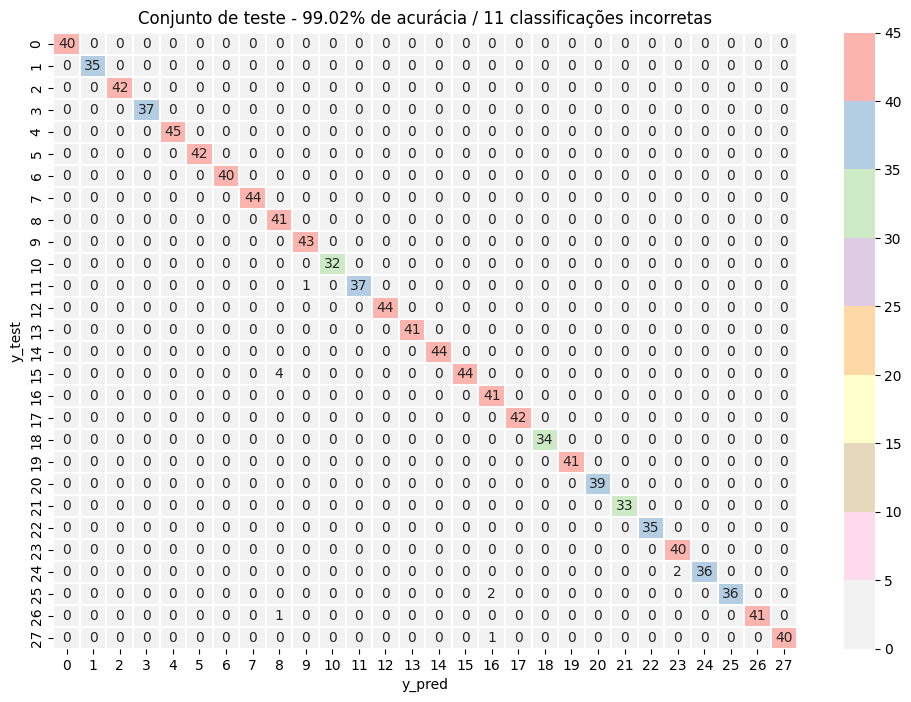

In [ ]:
y_pred = model.predict(input_test)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')

plt.show()

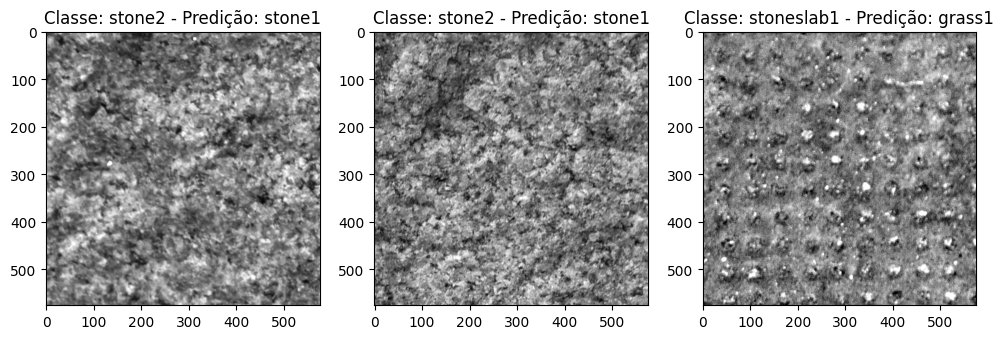

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_9 (FreqLayer)    (None, 504, 1)            504       
                                                                 
 flatten_9 (Flatten)         (None, 504)               0         
                                                                 
 dense_25 (Dense)            (None, 128)               64640     
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dense_27 (Dense)            (None, 28)                3612      
                                                                 
Total params: 85,268
Trainable params: 85,268
Non-trainable params: 0
_________________________________________________________________


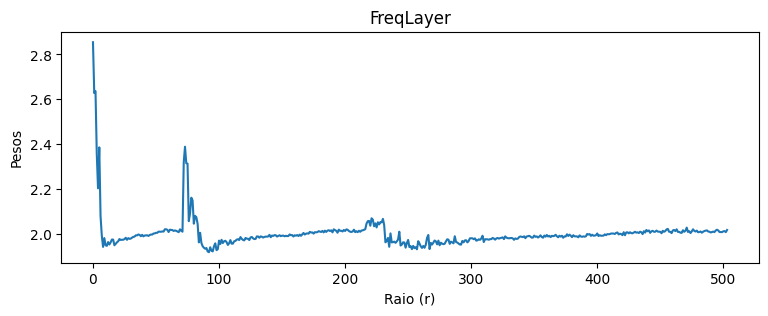

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

#### Model_2levels

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_2.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_2, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True) #8min15s

Epoch 1/500
336/336 [==============================] - 2s 3ms/step - loss: 1.6335 - accuracy: 0.5009
Epoch 2/500
336/336 [==============================] - 1s 3ms/step - loss: 0.6011 - accuracy: 0.8119
Epoch 3/500
336/336 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8759
Epoch 4/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2711 - accuracy: 0.9077
Epoch 5/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1970 - accuracy: 0.9301
Epoch 6/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2100 - accuracy: 0.9280
Epoch 7/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2038 - accuracy: 0.9283
Epoch 8/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1791 - accuracy: 0.9390
Epoch 9/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1881 - accuracy: 0.9363
Epoch 10/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1408 - accura

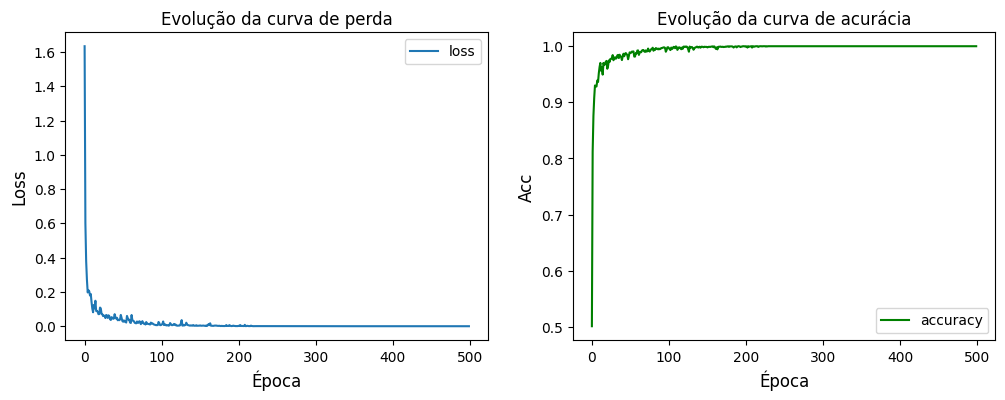

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test_2, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 3ms/step - loss: 0.0137 - accuracy: 0.9946

accuracy : 99.46%


35/35 [==============================] - 0s 1ms/step


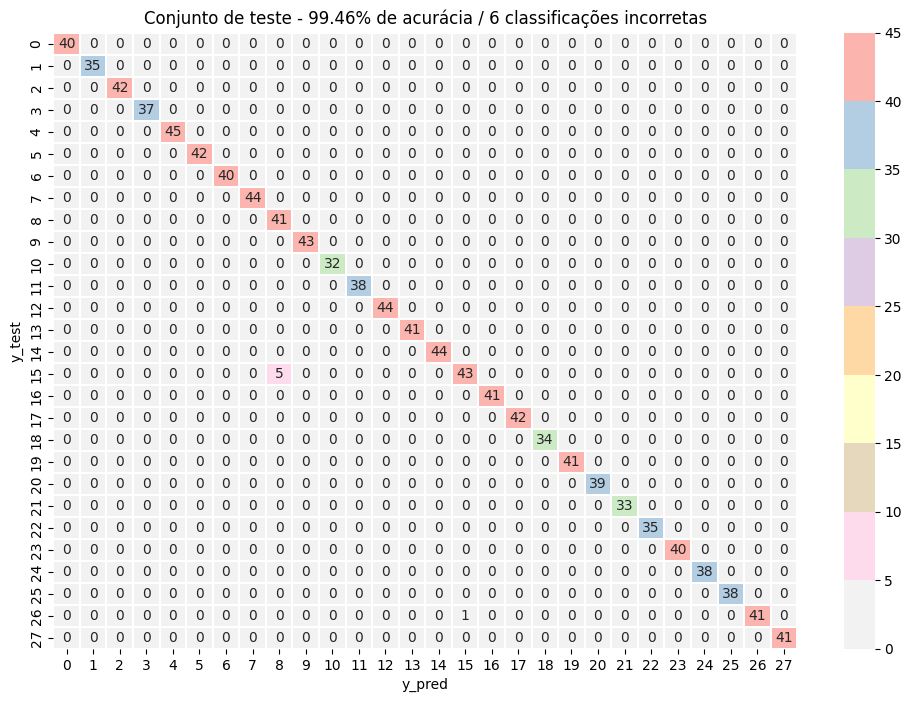

In [ ]:
y_pred = model.predict(input_test_2)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test_2.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

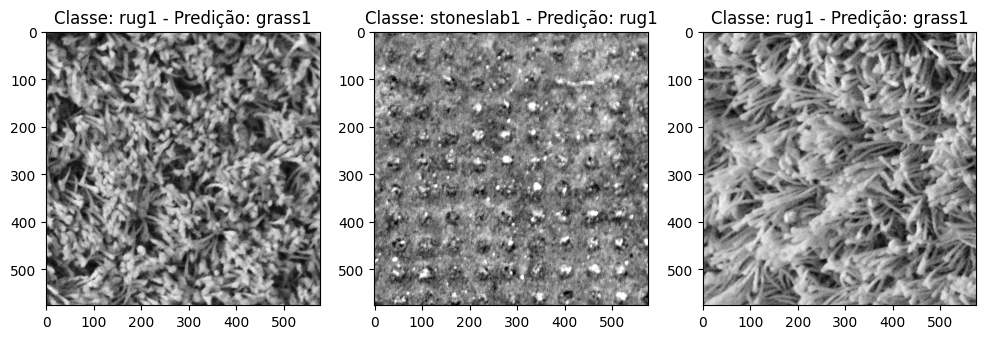

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_11 (FreqLayer)   (None, 864, 1)            864       
                                                                 
 flatten_10 (Flatten)        (None, 864)               0         
                                                                 
 dense_31 (Dense)            (None, 128)               110720    
                                                                 
 dense_32 (Dense)            (None, 128)               16512     
                                                                 
 dense_33 (Dense)            (None, 28)                3612      
                                                                 
Total params: 131,708
Trainable params: 131,708
Non-trainable params: 0
_________________________________________________________________


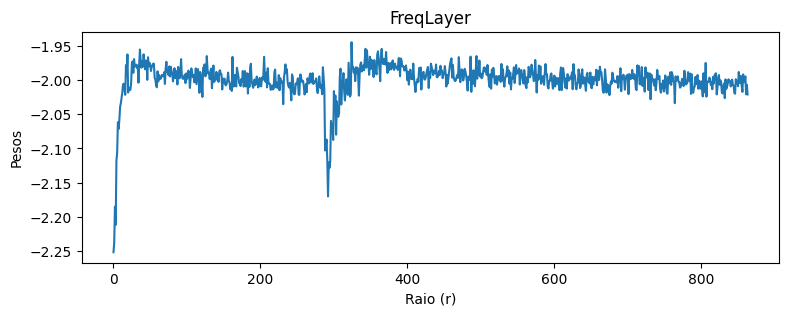

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()

#### Model_1level

In [ ]:
tf.random.set_seed(s)
init = 'glorot_normal'
function = 'relu'

model = Sequential([
    FreqLayer(1, kernel_initializer=tf.keras.initializers.RandomNormal(mean=-2, stddev=0.01)),
    Flatten(),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(128, activation=function,
          kernel_initializer=init, bias_initializer=init),
    Dense(28, activation='softmax')])

In [ ]:
### inverse time decay  ###
inversetime_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
  initial_learning_rate = 0.01, #0.01 - opt2 lr=0.001
  decay_steps = input_1.shape[0]/10,
  decay_rate = 0.005) #0.005 - opt2 dr=0.02/0.03/0.04/0.05/0.09 obtive 99,73

d_m=0.8 #momentum - dense layers

### optimizers ###
opt0 = SGD(learning_rate=inversetime_decay, momentum=d_m) #0.001
opt1 = RMSprop(learning_rate=inversetime_decay, momentum=d_m) #lr=0.001 dr=0.02
opt2 = Adam(learning_rate=inversetime_decay) #lr=0.001 dr=0.02
opt3 = Nadam(learning_rate=0.001) #lr=0.001 dr=0.02 //does not support scheduled decay
opt4 = tfrs.experimental.optimizers.CompositeOptimizer([
      (SGD(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights),
      (SGD(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[4].weights)])
opt5 = tfrs.experimental.optimizers.CompositeOptimizer([
      (RMSprop(learning_rate=inversetime_decay, momentum=0.0), lambda: [model.layers[0].kernel]),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[1].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[2].weights),
      (RMSprop(learning_rate=inversetime_decay, momentum=d_m), lambda: model.layers[3].weights)])
opt6 = tfa.optimizers.AdamW(weight_decay = 1/4*0.001)
opt7 = tfa.optimizers.COCOB(alpha=1000)
opt8 = tfa.optimizers.LAMB(learning_rate=0.001)

model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])
#earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=500) # patience = 15
history = model.fit(input_1, y_train, epochs=500, batch_size=10, verbose=1, shuffle=True)

Epoch 1/500
336/336 [==============================] - 2s 3ms/step - loss: 1.8089 - accuracy: 0.4670
Epoch 2/500
336/336 [==============================] - 1s 3ms/step - loss: 0.5842 - accuracy: 0.8158
Epoch 3/500
336/336 [==============================] - 1s 3ms/step - loss: 0.3329 - accuracy: 0.8896
Epoch 4/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2422 - accuracy: 0.9182
Epoch 5/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1938 - accuracy: 0.9336
Epoch 6/500
336/336 [==============================] - 1s 3ms/step - loss: 0.2140 - accuracy: 0.9298
Epoch 7/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1510 - accuracy: 0.9500
Epoch 8/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1662 - accuracy: 0.9420
Epoch 9/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1392 - accuracy: 0.9512
Epoch 10/500
336/336 [==============================] - 1s 3ms/step - loss: 0.1514 - accura

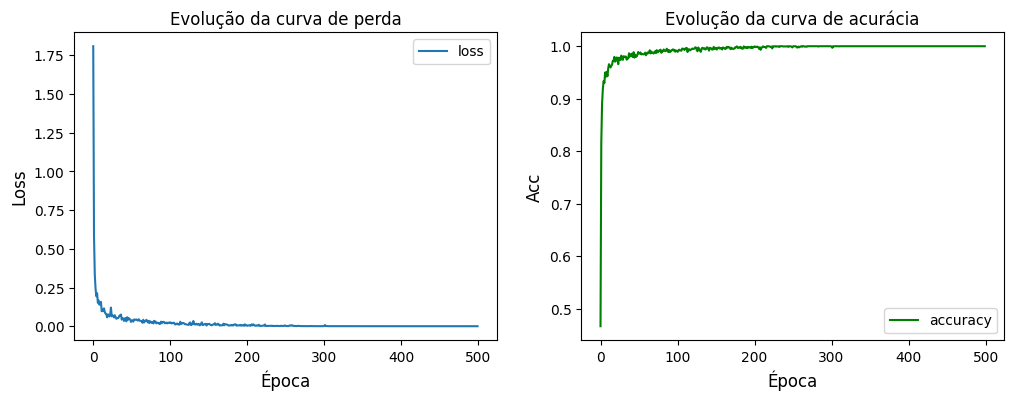

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(121), plt.plot(history.history['loss'], label='loss')
plt.xlabel('Época', fontsize=12), plt.ylabel('Loss', fontsize=12)
plt.title('Evolução da curva de perda')
plt.legend()
plt.subplot(122), plt.plot(history.history['accuracy'], label = 'accuracy', color='green')
plt.xlabel('Época', fontsize=12), plt.ylabel('Acc', fontsize=12)
plt.title('Evolução da curva de acurácia')
plt.legend()
plt.show()

In [ ]:
### TEST ACC ###
scores = model.evaluate(input_test_1, y_test)
print('\n%s : %.2f%%' % (model.metrics_names[1], scores[1] * 100))

35/35 [==============================] - 0s 2ms/step - loss: 0.0284 - accuracy: 0.9902

accuracy : 99.02%


35/35 [==============================] - 0s 1ms/step


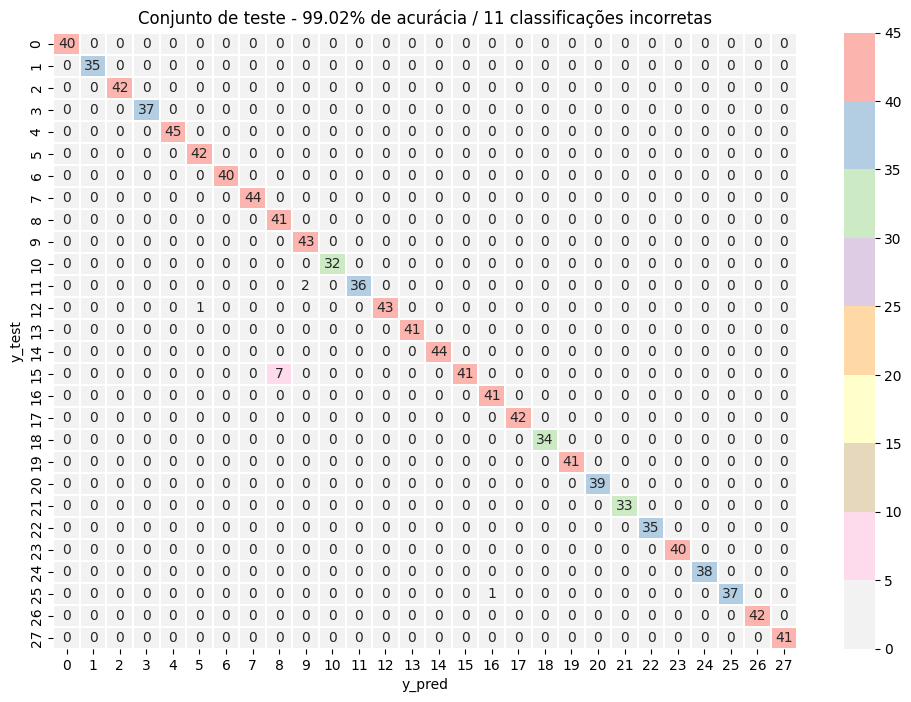

In [ ]:
y_pred = model.predict(input_test_1)
plt.figure(figsize = (12,8))
cm = confusion_matrix(tf.argmax(y_test, axis=1), tf.argmax(y_pred, axis=1))
acc = np.trace(cm)/input_test_1.shape[0] * 100
erros = tf.reduce_sum(cm)-tf.linalg.trace(cm)
plt.title('Conjunto de teste - %.2f%% de acurácia / %d classificações incorretas' % (acc, erros))
sn.heatmap(cm, cmap='Pastel1_r', linewidths=.1, annot=True)
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
dic = {0:'blanket1',1:'blanket2',2:'canvas1',3:'ceiling1',4:'ceiling2',5:'cushion1',
       6:'floor1',7:'floor2',8:'grass1',9:'lentils1',10:'linseeds1',11:'oatmeal1',
       12:'pearlsugar1',13:'rice1',14:'rice2',15:'rug1',16:'sand1',17:'scarf1',
       18:'scarf2',19:'screen1',20:'seat1',21:'seat2',22:'sesameseeds1',23:'stone1',
       24:'stone2',25:'stone3',26:'stoneslab1',27:'wall1'}

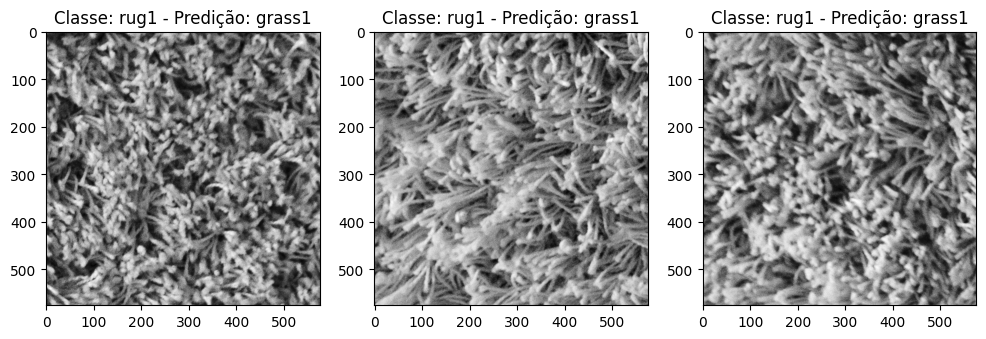

In [ ]:
dif = tf.argmax(y_test, axis=1)-tf.argmax(y_pred, axis=1)
indices = np.where(dif!=0)[0]

plt.figure(figsize=(12,6))
plt.subplot(131), plt.imshow(tf.squeeze(x_test[indices[0]]), cmap='gray')
r1 = tf.argmax(y_test, axis=1)[indices[0]]
f1 = tf.argmax(y_pred, axis=1)[indices[0]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r1)], dic[int(f1)]))
plt.subplot(132), plt.imshow(tf.squeeze(x_test[indices[1]]), cmap='gray')
r2 = tf.argmax(y_test, axis=1)[indices[1]]
f2 = tf.argmax(y_pred, axis=1)[indices[1]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r2)], dic[int(f2)]))
plt.subplot(133), plt.imshow(tf.squeeze(x_test[indices[2]]), cmap='gray')
r3 = tf.argmax(y_test, axis=1)[indices[2]]
f3 = tf.argmax(y_pred, axis=1)[indices[2]]
plt.title('Classe: %s - Predição: %s' % (dic[int(r3)], dic[int(f3)]))
plt.show()

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 freq_layer_13 (FreqLayer)   (None, 288, 1)            288       
                                                                 
 flatten_11 (Flatten)        (None, 288)               0         
                                                                 
 dense_37 (Dense)            (None, 128)               36992     
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dense_39 (Dense)            (None, 28)                3612      
                                                                 
Total params: 57,404
Trainable params: 57,404
Non-trainable params: 0
_________________________________________________________________


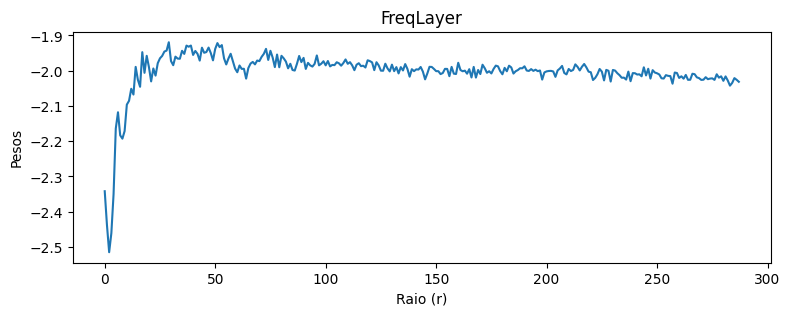

In [ ]:
plt.figure(figsize=(9,3))
plt.plot(model.get_weights()[0])
plt.title('FreqLayer')
plt.xlabel('Raio (r)'), plt.ylabel('Pesos')
plt.show()